<a href="https://colab.research.google.com/github/rmynzl/calismalarim/blob/main/234329040_Say%C4%B1sal_G%C3%B6r%C3%BCnt%C3%BC_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# gerekli kütüphaneleri yüklüyorum

import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
from skimage import exposure
from skimage.filters import median, gaussian, threshold_otsu, try_all_threshold
from skimage.morphology import disk, closing, opening
from skimage.measure import label, regionprops
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import seaborn as sns
sns.set()

### Veriyi Çekme İşlemi

In [3]:
!git clone https://github.com/hardik0/AI-for-Medicine-Specialization
%cd AI-for-Medicine-Specialization/AI-for-Medical-Diagnosis/

Cloning into 'AI-for-Medicine-Specialization'...
remote: Enumerating objects: 1601, done.
remote: Counting objects: 100% (28/28), done.
remote: Compressing objects: 100% (28/28), done.
remote: Total 1601 (delta 9), reused 2 (delta 0), pack-reused 1573 (from 1)
Receiving objects: 100% (1601/1601), 720.36 MiB | 27.16 MiB/s, done.
Resolving deltas: 100% (30/30), done.
Updating files: 100% (1497/1497), done.
/content/AI-for-Medicine-Specialization/AI-for-Medical-Diagnosis


In [4]:
!ls nih/


densenet.hdf5  images_small  pretrained_model.h5  test.csv  train-small.csv  valid-small.csv


In [5]:
import pandas as pd

# Read CSV file containing training data
train_df = pd.read_csv("nih/train-small.csv")

# Print dataset shape
print(f'There are {train_df.shape[0]} rows and {train_df.shape[1]} columns in this data frame')

# Display first 5 rows
train_df.head()  # Jupyter Notebook'ta çalışıyorsan bu yeterli
# print(train_df.head())  # Terminal veya standart Python ortamında çalışıyorsan bunu kullan


There are 1000 rows and 16 columns in this data frame


,Image,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,PatientId,Pleural_Thickening,Pneumonia,Pneumothorax
0,00008270_015.png,0,0,0,0,0,0,0,0,0,0,0,8270,0,0,0
1,00029855_001.png,1,0,0,0,1,0,0,0,1,0,0,29855,0,0,0
2,00001297_000.png,0,0,0,0,0,0,0,0,0,0,0,1297,1,0,0
3,00012359_002.png,0,0,0,0,0,0,0,0,0,0,0,12359,0,0,0
4,00017951_001.png,0,0,0,0,0,0,0,0,1,0,0,17951,0,0,0


#### Veri kümesi 1000 satır ve 16 sütundan oluşuyor.

* "Image" sütunu, görüntü dosya adlarını içeriyor.
* Hasta kimliği ("PatientId") her satırda mevcut.
* Hastalıklara ait etiketler (Atelectasis, Edema, Pneumonia vb.) 0 veya 1 olarak kodlanmış (1 → Hastalık var, 0 → Yok).

In [6]:
# Look at the data type of each column and whether null values are present
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Image               1000 non-null   object
 1   Atelectasis         1000 non-null   int64 
 2   Cardiomegaly        1000 non-null   int64 
 3   Consolidation       1000 non-null   int64 
 4   Edema               1000 non-null   int64 
 5   Effusion            1000 non-null   int64 
 6   Emphysema           1000 non-null   int64 
 7   Fibrosis            1000 non-null   int64 
 8   Hernia              1000 non-null   int64 
 9   Infiltration        1000 non-null   int64 
 10  Mass                1000 non-null   int64 
 11  Nodule              1000 non-null   int64 
 12  PatientId           1000 non-null   int64 
 13  Pleural_Thickening  1000 non-null   int64 
 14  Pneumonia           1000 non-null   int64 
 15  Pneumothorax        1000 non-null   int64 
dtypes: int64(15), object(1)
m

# Rasgele 9 görsel seçiyorum

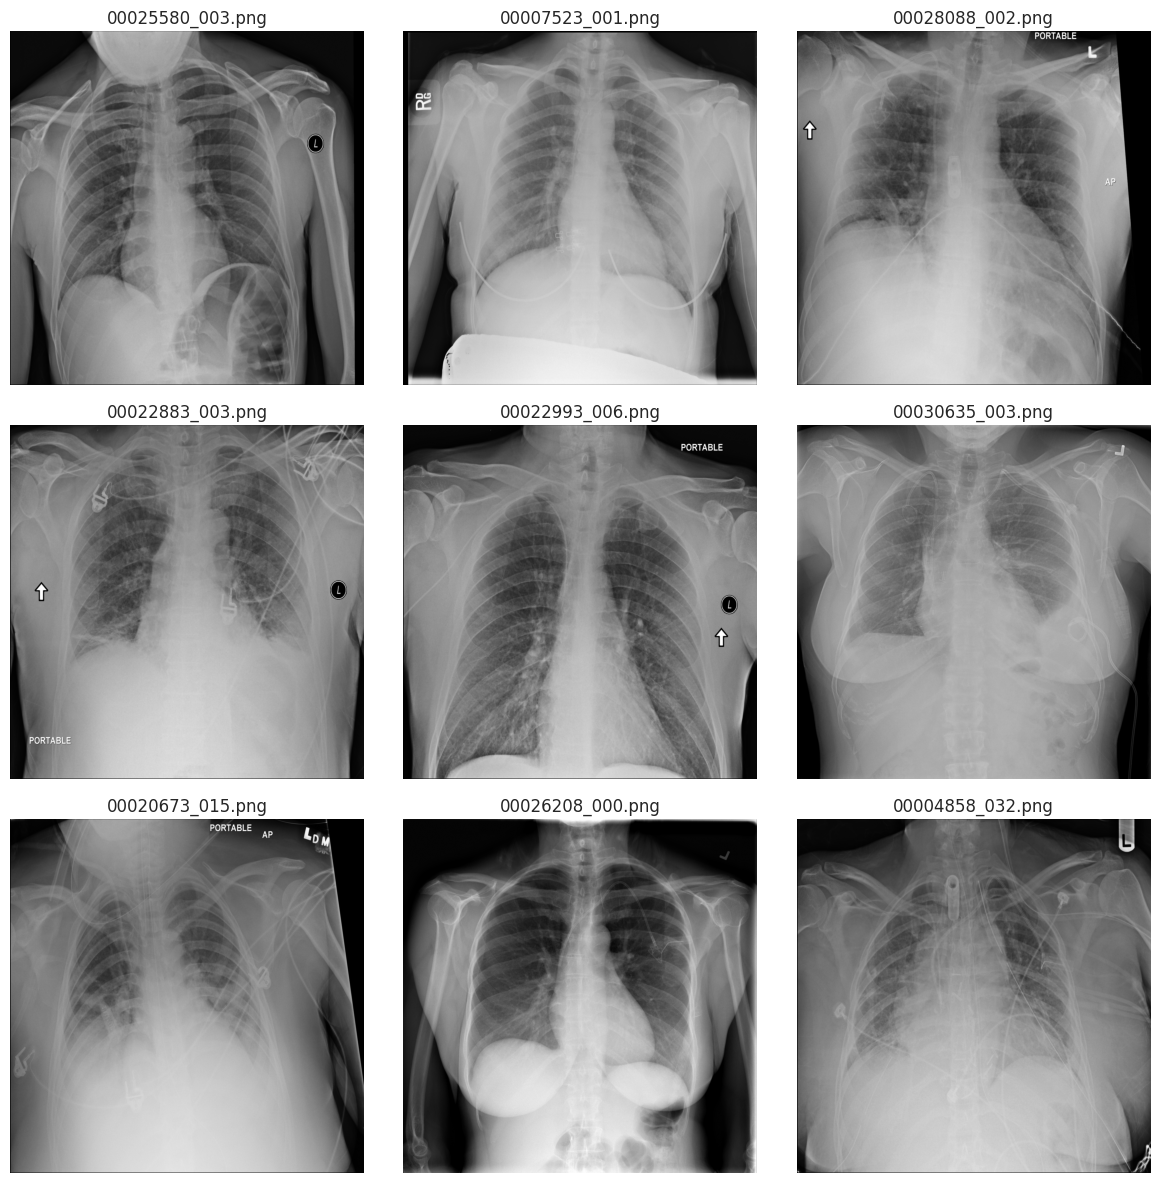

In [7]:
import matplotlib.pyplot as plt
import cv2
import random

image_folder = "nih/images_small/"

# Rastgele 9 görüntü seçiyoruz
random_images = train_df.sample(9)["Image"].values

# Görselleri çiziyoruz
fig, axes = plt.subplots(3, 3, figsize=(12, 12))

for ax, img_name in zip(axes.ravel(), random_images):
    img_path = image_folder + img_name
    img = cv2.imread(img_path, 0)

    ax.imshow(img, cmap='gray')
    ax.set_title(img_name)
    ax.axis("off")

plt.tight_layout()
plt.show()


* Bu kod, veri kümesinden rastgele 9 görüntü seçip, bunları siyah-beyaz (grayscale) olarak yüklüyor ve ekranda bir 3x3 ızgara halinde gösteriyor. Her görüntünün üstüne dosya adını başlık olarak ekliyor, böylece hangi görüntüye baktığımızı anlayabiliyoruz. Sonuç olarak, farklı hastaların röntgen görüntülerini hızlıca inceleyebileceğimiz bir görselleştirme sağlanıyor.

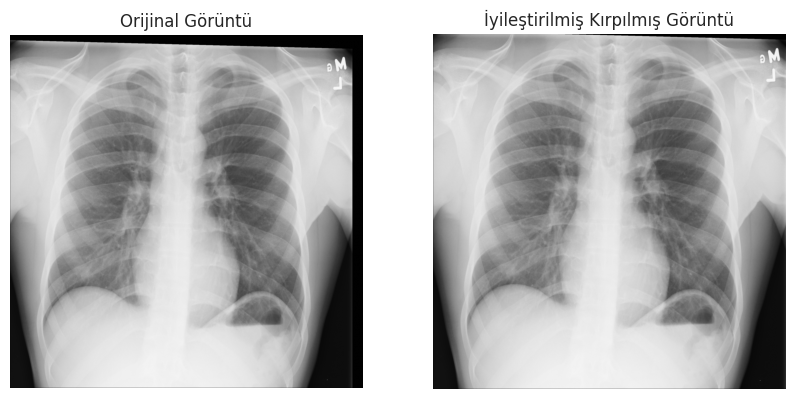

In [8]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def improved_crop_lungs(image_path):

    img = cv2.imread(image_path, 0)

    # Histogram eşitleme (kontrast artırma)
    img_eq = cv2.equalizeHist(img)

    # Gürültüyü azaltmak için Gaussian Blur uyguluyoruz
    img_blur = cv2.GaussianBlur(img_eq, (5, 5), 0)

    # Otsu Thresholding ile binarize ediuorum
    _, thresh = cv2.threshold(img_blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Morfolojik açma işlemi (gürültüleri temizleme)
    kernel = np.ones((5, 5), np.uint8)
    thresh = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)

    # Konturlar (sınırlar) bulalım
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if not contours:
        print("Hata: Akciğer bölgesi bulunamadı.")
        return img

    # En büyük alanı kapsayan konturu seçiyorum
    largest_contour = max(contours, key=cv2.contourArea)

    # Kontura göre dikdörtgen çiziuoum
    x, y, w, h = cv2.boundingRect(largest_contour)

    # Görüntüyü kırpıyorum
    cropped_img = img[y:y+h, x:x+w]

    return cropped_img

# Test etmek için rastgele bir görüntü seçiyorum
sample_image = "nih/images_small/" + train_df.sample(1)["Image"].values[0]
cropped = improved_crop_lungs(sample_image)

# Orijinal ve Kırpılmış Görüntüyü Yan Yana Gösteriyorum
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(cv2.imread(sample_image, 0), cmap="gray")
axes[0].set_title("Orijinal Görüntü")
axes[0].axis("off")

axes[1].imshow(cropped, cmap="gray")
axes[1].set_title("İyileştirilmiş Kırpılmış Görüntü")
axes[1].axis("off")

plt.show()


* İlk olarak, histogram eşitleme ile görüntünün kontrastını artırıyorum. Ardından, Gaussian Blur uygulayarak görüntüdeki gürültüyü azaltıyorum. Otsu Thresholding yöntemiyle görüntüyü ikili hale getiriyorum. Sonrasında, morfolojik açma işlemi ile gürültüyü temizliyorum. Kontur bulma ile akciğer bölgesini tespit edip, en büyük konturu seçiyorum. Son olarak, bu kontura göre görüntüyü kırpıyor ve hem orijinal hem de kırpılmış görüntüyü yan yana görselleştiriyorum.

In [10]:
def contrast_stretching(img):
    min_val = np.min(img)
    max_val = np.max(img)
    stretched = (img - min_val) / (max_val - min_val) * 255
    return stretched.astype(np.uint8)

# Kırpılmış görüntüyü alalım
cropped_img = improved_crop_lungs(sample_image)

# Kontrast Germe uygulayalım
contrast_img = contrast_stretching(cropped_img)


* Burada kırpılmış görüntüye kontrast germe işlemi uyguluyorum. İlk olarak, contrast_stretching fonksiyonu ile görüntüdeki minimum ve maksimum piksel değerleri tespit ediyorum. Ardından, bu değerler arasındaki farkı 0 ile 255 arasına genişleterek görüntünün kontrastını artırıyorum. Bu işlem, daha belirgin ayrıntılar ortaya çıkararak görüntünün kalitesini iyileştiriyor. Sonuç olarak, kırpılmış görüntüye kontrast germe işlemi uygulanmış oluyor.

In [11]:
def histogram_equalization(img):
    return cv2.equalizeHist(img)

# Histogram Eşitleme uygulayalım
equalized_img = histogram_equalization(cropped_img)


* Burada kırpılmış görüntüye histogram eşitleme uyguluyorum. cv2.equalizeHist fonksiyonuyla görüntünün kontrastını artırarak, daha net detaylar elde ediyorum.

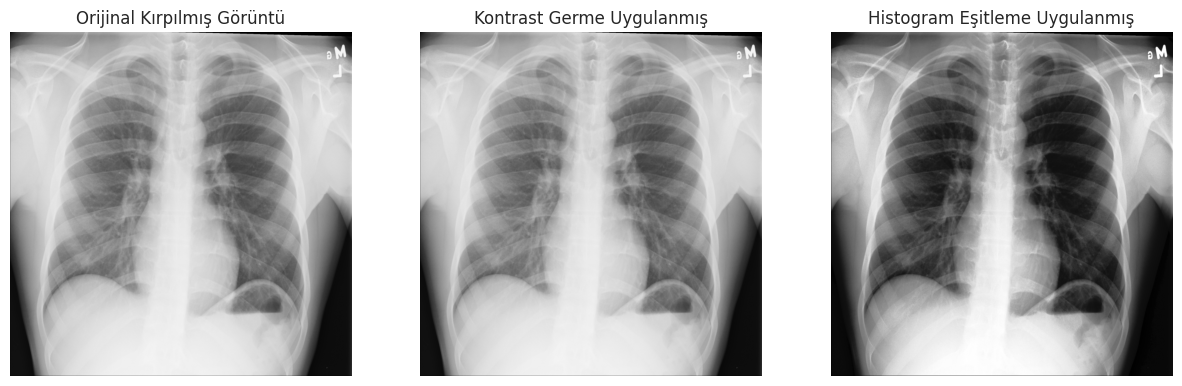

In [12]:
# Görselleri Yan Yana Gösteriuotum
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(cropped_img, cmap="gray")
axes[0].set_title("Orijinal Kırpılmış Görüntü")
axes[0].axis("off")

axes[1].imshow(contrast_img, cmap="gray")
axes[1].set_title("Kontrast Germe Uygulanmış")
axes[1].axis("off")

axes[2].imshow(equalized_img, cmap="gray")
axes[2].set_title("Histogram Eşitleme Uygulanmış")
axes[2].axis("off")

plt.show()


* Şimdi üç farklı görüntüyü yan yana gösteriyorum. İlk olarak, orijinal kırpılmış görüntüyü gösteriyorum. Ardından, kontrast germe uygulanmış görüntüyü ve son olarak da histogram eşitleme uygulanmış görüntüyü yan yana sunuyorum.

* Sonuç: Histogram Eşitleme en iyi sonucu veriyor, model eğitimi için daha uygun.

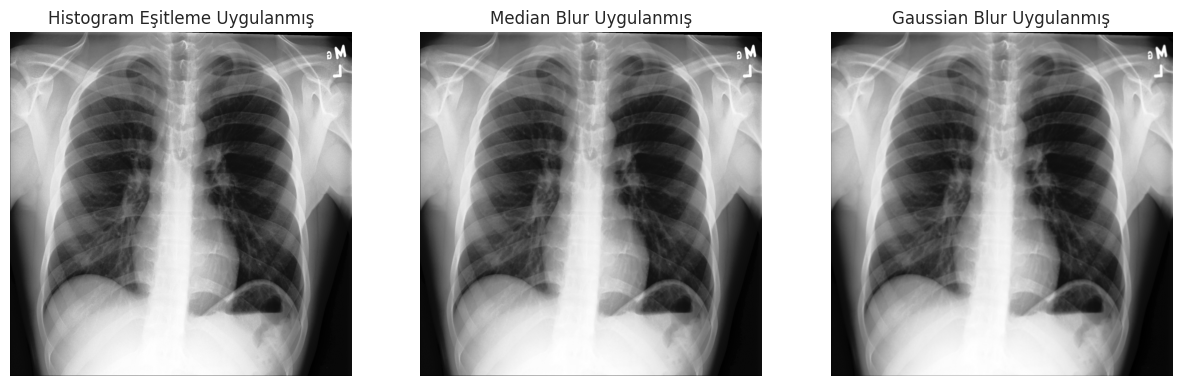

In [13]:
import cv2
import matplotlib.pyplot as plt

# Median Blur Uygulaması
median_blur_img = cv2.medianBlur(equalized_img, 3)

# Gaussian Blur Uygulaması
gaussian_blur_img = cv2.GaussianBlur(equalized_img, (5, 5), 0)

# Görselleri Yan Yana Gösteriyorum
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(equalized_img, cmap="gray")
axes[0].set_title("Histogram Eşitleme Uygulanmış")
axes[0].axis("off")

axes[1].imshow(median_blur_img, cmap="gray")
axes[1].set_title("Median Blur Uygulanmış")
axes[1].axis("off")

axes[2].imshow(gaussian_blur_img, cmap="gray")
axes[2].set_title("Gaussian Blur Uygulanmış")
axes[2].axis("off")

plt.show()


* Histogram eşitleme uygulanmış görüntüye iki farklı bulanıklaştırma (blur) işlemi yapıyorum. İlk olarak, Median Blur uygulanmış görüntüyü, ardından Gaussian Blur uygulanmış görüntüyü gösteriyorum.

- Histogram Eşitleme: Kontrastı artırarak detayları belirginleştirmiş.
- Median Blur: Gürültüyü azaltmış ama bazı detayları kaybettirmiş.
- Gaussian Blur: Daha doğal bir yumuşatma sağlamış, detaylar korunmuş.

* Sonuç: Gaussian Blur en dengeli seçenek gibi görünüyor.

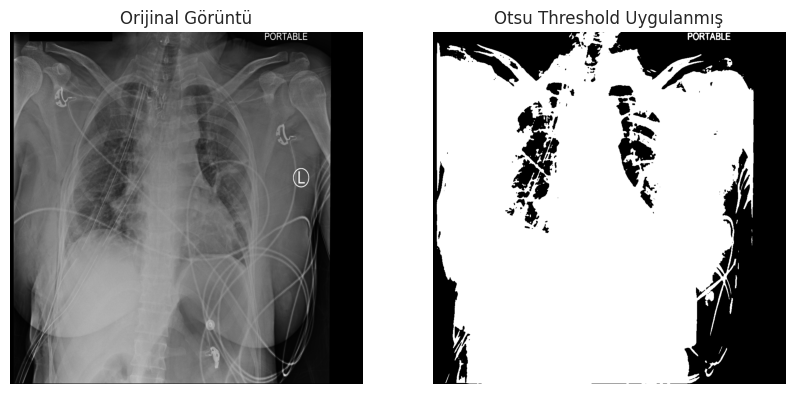

In [14]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def apply_threshold(image_path):

    img = cv2.imread(image_path, 0)

    # Gürültüyü azaltmak için Gaussian Blur uygulaması yapıyırum
    blurred = cv2.GaussianBlur(img, (5,5), 0)

    # Otsu Thresholding uyguluyorum
    _, binary_otsu = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    return img, binary_otsu

# Örnek bir görüntü kullanarak test edelim
sample_image = "nih/images_small/" + train_df.sample(1)["Image"].values[0]
original, thresholded = apply_threshold(sample_image)

# Sonuçları görselleştiriyorum
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(original, cmap="gray")
axes[0].set_title("Orijinal Görüntü")
axes[0].axis("off")

axes[1].imshow(thresholded, cmap="gray")
axes[1].set_title("Otsu Threshold Uygulanmış")
axes[1].axis("off")

plt.show()


* Bir görüntüye Otsu Thresholding işlemi uyguluyorum. İlk olarak, görüntüye Gaussian Blur uygulayarak gürültüyü azaltıyorum. Ardından, Otsu Thresholding ile görüntüyü ikili hale getiriyorum. Son olarak, orijinal ve thresholding uygulanmış görüntüleri yan yana göstererek işlemin etkisini görselleştiriyorum.

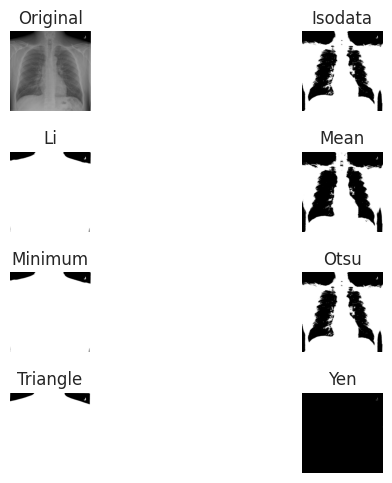

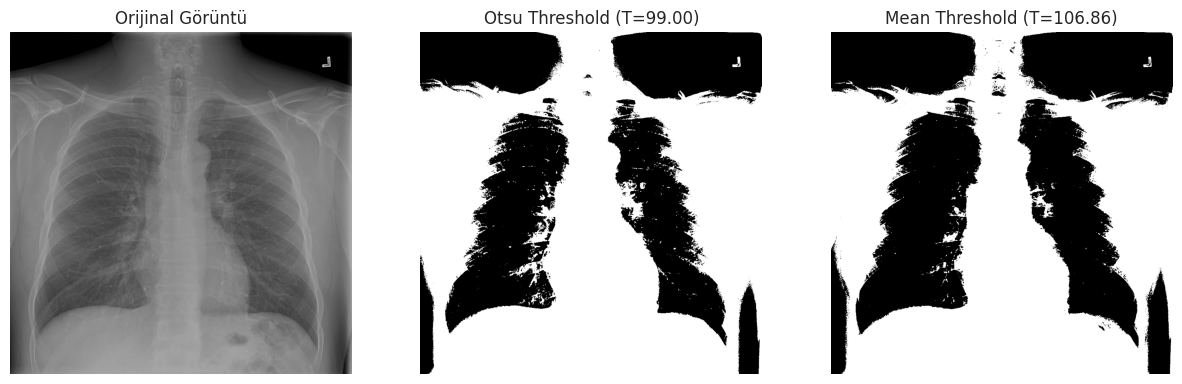

In [27]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, filters
from skimage.filters import try_all_threshold, threshold_otsu, threshold_li, threshold_mean
from skimage.color import rgb2gray

def apply_thresholds(image_path):

    img = io.imread(image_path)

    # Eğer görüntü renkliyse gri tona çeviriyoum
    if len(img.shape) == 3:
        img = rgb2gray(img)

    # Otsu Thresholding
    otsu_thresh = threshold_otsu(img)
    binary_otsu = img > otsu_thresh

    # Mean Thresholding
    mean_thresh = threshold_mean(img)
    binary_mean = img > mean_thresh

    # Skimage try_all_threshold ile tüm eşikleme yöntemlerini göstereim
    fig, ax = try_all_threshold(img, verbose=False)
    plt.show()

    return img, binary_otsu, binary_mean, otsu_thresh, mean_thresh

# Örnek bir görüntü seçiyorum
sample_image = "nih/images_small/" + train_df.sample(1)["Image"].values[0]

# Thresholding uygulaması
original, binary_otsu, binary_mean, otsu_thresh, mean_thresh = apply_thresholds(sample_image)

# Sonuçları görselleştiriyorum
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(original, cmap="gray")
axes[0].set_title("Orijinal Görüntü")
axes[0].axis("off")

axes[1].imshow(binary_otsu, cmap="gray")
axes[1].set_title(f"Otsu Threshold (T={otsu_thresh:.2f})")
axes[1].axis("off")

axes[2].imshow(binary_mean, cmap="gray")
axes[2].set_title(f"Mean Threshold (T={mean_thresh:.2f})")
axes[2].axis("off")

plt.show()


* Otsu Thresholding genellikle daha iyi sonuç verir çünkü görüntünün histogramını kullanarak en uygun eşik değerini otomatik olarak belirler.
* Mean Thresholding ise sadece piksellerin ortalama değeriyle çalışır, bu da özellikle düşük kontrastlı görüntülerde etkili olmayabilir.
* Otsu yöntemi, genellikle iyi aydınlatılmış ve düşük gürültülü görüntülerde daha başarılıdır.

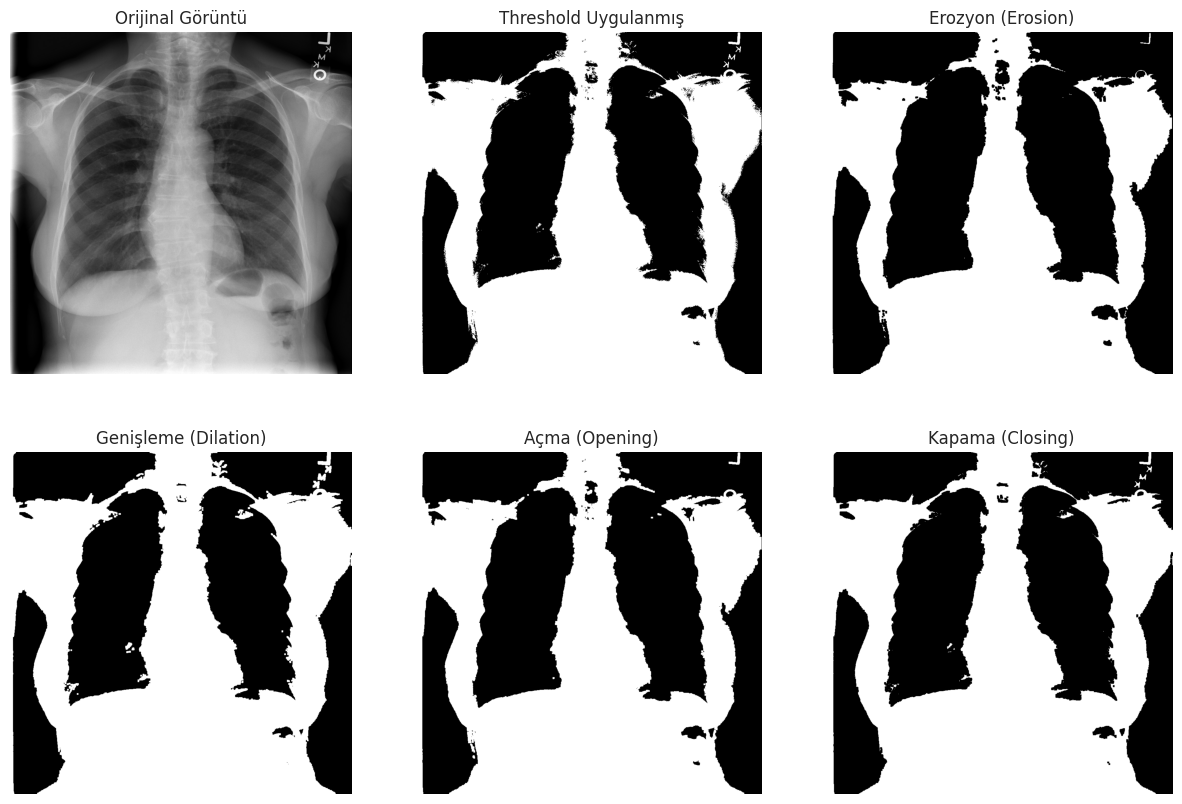

In [28]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, morphology
from skimage.color import rgb2gray

def apply_morphological_operations(image_path):
    # Görüntüyü okutuyorum (gri tonlamaya çevir)
    img = io.imread(image_path)
    if len(img.shape) == 3:
        img = rgb2gray(img)

    # Thresholding uygulaması (Otsu yöntemi)
    otsu_thresh = filters.threshold_otsu(img)
    binary = img > otsu_thresh

    # Structural element (kernel) seçimi
    kernel = np.ones((5, 5), np.uint8)  # 5x5 kare çekirdek

    # Morfolojik işlemler
    erosion = cv2.erode(binary.astype(np.uint8), kernel, iterations=1)  # Erozyon
    dilation = cv2.dilate(binary.astype(np.uint8), kernel, iterations=1)  # Genişleme
    opening = cv2.morphologyEx(binary.astype(np.uint8), cv2.MORPH_OPEN, kernel)  # Açma
    closing = cv2.morphologyEx(binary.astype(np.uint8), cv2.MORPH_CLOSE, kernel)  # Kapama

    return img, binary, erosion, dilation, opening, closing

# Örnek görüntü
sample_image = "nih/images_small/" + train_df.sample(1)["Image"].values[0]

# İşlemleri uyguluyorum
original, binary, erosion, dilation, opening, closing = apply_morphological_operations(sample_image)

# Sonuçları görselleştiriyorum
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

axes[0, 0].imshow(original, cmap="gray")
axes[0, 0].set_title("Orijinal Görüntü")
axes[0, 0].axis("off")

axes[0, 1].imshow(binary, cmap="gray")
axes[0, 1].set_title("Threshold Uygulanmış")
axes[0, 1].axis("off")

axes[0, 2].imshow(erosion, cmap="gray")
axes[0, 2].set_title("Erozyon (Erosion)")
axes[0, 2].axis("off")

axes[1, 0].imshow(dilation, cmap="gray")
axes[1, 0].set_title("Genişleme (Dilation)")
axes[1, 0].axis("off")

axes[1, 1].imshow(opening, cmap="gray")
axes[1, 1].set_title("Açma (Opening)")
axes[1, 1].axis("off")

axes[1, 2].imshow(closing, cmap="gray")
axes[1, 2].set_title("Kapama (Closing)")
axes[1, 2].axis("off")

plt.show()



* Erozyon (Erosion): Küçük gürültüleri yok eder ama ince detayları kaybettirebilir.
* Genişleme (Dilation): Nesneleri büyütür, bazı eksik pikselleri tamamlar.
* Açma (Opening): Gürültüyü temizlemek için iyi bir yöntemdir (erosyon + genişleme).
* Kapama (Closing): Nesneleri daha bütün hale getirir, delikleri kapatır.


Bağlantılı bileşen sayısı (CCL sonucu): 493


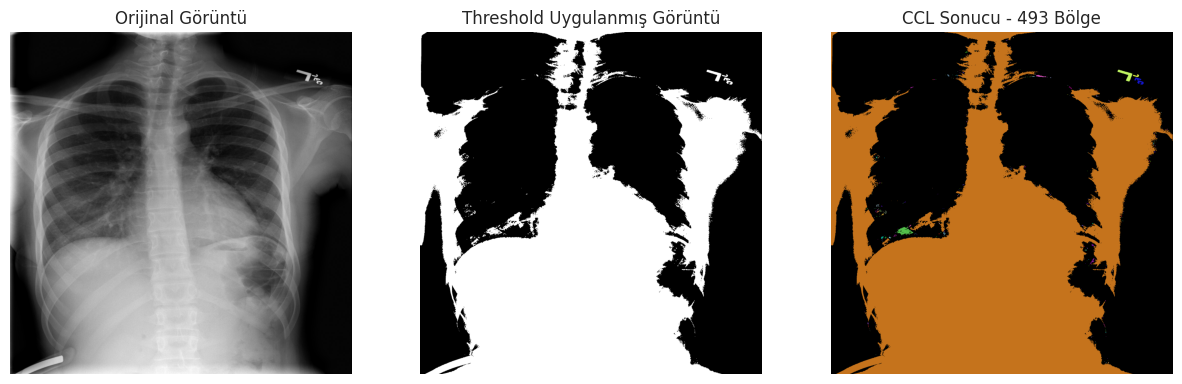

In [30]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
from skimage.color import rgb2gray
from skimage.filters import threshold_otsu


def apply_connected_components(image_path):
    # Görüntüyü okutuyorum ve gri tona çeviriyorum
    img = io.imread(image_path)
    if len(img.shape) == 3:
        img = rgb2gray(img)

    # Otsu thresholding uygulamsı
    otsu_thresh = threshold_otsu(img)
    binary = (img > otsu_thresh).astype(np.uint8)

    # Bağlantı bileşenlerini bulalım
    num_labels, labels = cv2.connectedComponents(binary)

    print(f"Bağlantılı bileşen sayısı (CCL sonucu): {num_labels - 1}")  # Arka planı çıkartmak için

    return img, binary, labels, num_labels


# Örnek görüntü seçelim
sample_image = "nih/images_small/" + train_df.sample(1)["Image"].values[0]

# CCL işlemini uygulayalım
original, binary, labels, num_labels = apply_connected_components(sample_image)

# CCL sonuçları
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(original, cmap="gray")
axes[0].set_title("Orijinal Görüntü")
axes[0].axis("off")

axes[1].imshow(binary, cmap="gray")
axes[1].set_title("Threshold Uygulanmış Görüntü")
axes[1].axis("off")

# Bağlantılı bileşenler için rastgele renkler atıyorum
colored_labels = np.random.rand(num_labels, 3)  # Her label için rastgele renk
label_image = np.zeros((*labels.shape, 3))  # RGB formatında boş bir görüntü
for i in range(1, num_labels):  # Arka planı (label=0) atlıyoruz bu satır ile
    label_image[labels == i] = colored_labels[i]

axes[2].imshow(label_image)
axes[2].set_title(f"CCL Sonucu - {num_labels-1} Bölge")
axes[2].axis("off")

plt.show()


* Burada, görüntüye Otsu Thresholding uygulayıp ardından Bağlantı Bileşenleri Analizi (CCL) yapıyorum. İlk olarak, görüntüyü ikili hale getiriyorum.
- Bağlantılı bileşen sayısı: Görüntüdeki ayrı nesnelerin sayısını gösteriyor.
- Bağlantılı bileşenlerin renkli görüntüsü: Her bölge farklı renkle görselleştiriliyor.
- Sonuçta, arka plan hariç olan bölge sayısı yazdırılır ve görüntülerde gösterilir.

* Bağlantılı bileşen sayısı 493, görüntüde 493 ayrı nesne veya bölge olduğunu gösterir. Arka plan çıkarıldığında, bu sayede 965 farklı bağlantılı alan bulunmuş demektir.

Toplam Bağlantılı Bölge Sayısı (Arka plan hariç): 369
Alan - Ortalama: 1678.6837837837838, Min: 1.0, Max: 613539.0
Eksantriklik - Ortalama: 0.53, Min: 0.00, Max: 1.00
Dolguluk - Ortalama: 0.91, Min: 0.37, Max: 1.00
Kaplama Oranı - Ortalama: 0.80, Min: 0.16, Max: 1.00
Çevre Uzunluğu - Ortalama: 59.29, Min: 0.00, Max: 17726.25


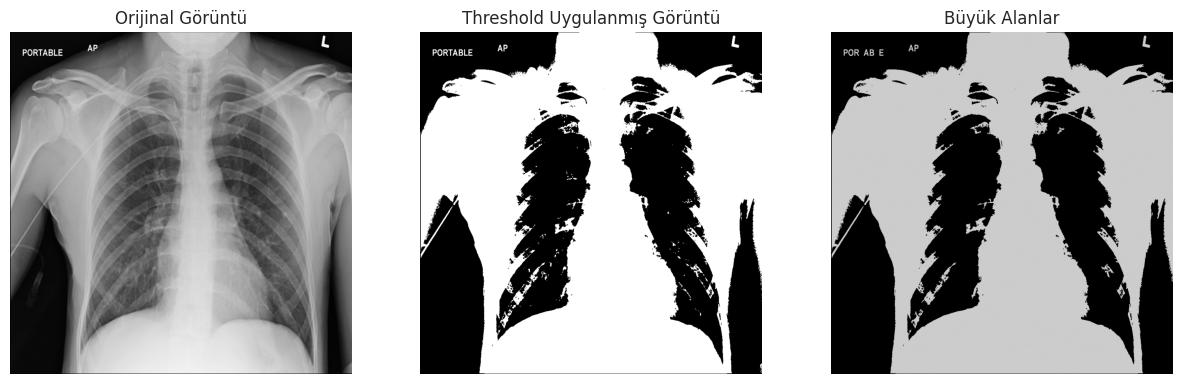

In [31]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, measure
from skimage.color import rgb2gray
from skimage.filters import threshold_otsu

def analyze_connected_components(image_path):

    img = io.imread(image_path)
    if len(img.shape) == 3:
        img = rgb2gray(img)

    # Otsu thresholding uygulaması
    otsu_thresh = threshold_otsu(img)
    binary = (img > otsu_thresh).astype(np.uint8)

    # Bağlantılı bileşenleri bualım (CCL)
    labeled_img, num_labels = measure.label(binary, connectivity=2, return_num=True)

    # Her bölge için özellikleri hesaplıyorum
    props = measure.regionprops(labeled_img, intensity_image=img)

    # Genel istatistikleri hesaplıyorum
    areas = [region.area for region in props]
    eccentricities = [region.eccentricity for region in props]
    solidities = [region.solidity for region in props]
    extents = [region.extent for region in props]
    perimeters = [region.perimeter for region in props]

    print(f"Toplam Bağlantılı Bölge Sayısı (Arka plan hariç): {num_labels - 1}")

    # Genel istatistikler
    print(f"Alan - Ortalama: {np.mean(areas)}, Min: {min(areas)}, Max: {max(areas)}")
    print(f"Eksantriklik - Ortalama: {np.mean(eccentricities):.2f}, Min: {min(eccentricities):.2f}, Max: {max(eccentricities):.2f}")
    print(f"Dolguluk - Ortalama: {np.mean(solidities):.2f}, Min: {min(solidities):.2f}, Max: {max(solidities):.2f}")
    print(f"Kaplama Oranı - Ortalama: {np.mean(extents):.2f}, Min: {min(extents):.2f}, Max: {max(extents):.2f}")
    print(f"Çevre Uzunluğu - Ortalama: {np.mean(perimeters):.2f}, Min: {min(perimeters):.2f}, Max: {max(perimeters):.2f}")

    return img, binary, labeled_img, props, areas, eccentricities

def visualize_components(labeled_img, props, areas, eccentricities):
    # Görselleştirmesi
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Orijinal görüntü
    axes[0].imshow(original, cmap="gray")
    axes[0].set_title("Orijinal Görüntü")
    axes[0].axis("off")

    # Threshold uygulanmış görüntü
    axes[1].imshow(binary, cmap="gray")
    axes[1].set_title("Threshold Uygulanmış Görüntü")
    axes[1].axis("off")

    # Bağlantılı bileşenler ve büyük alanlar
    large_area_img = np.zeros_like(labeled_img)
    large_areas = [region for region in props if region.area > 100]
    for region in large_areas:
        large_area_img[labeled_img == region.label] = 1

    axes[2].imshow(large_area_img, cmap="nipy_spectral")
    axes[2].set_title("Büyük Alanlar")
    axes[2].axis("off")

    plt.show()

# Örnek bir görüntü seçelim
sample_image = "nih/images_small/" + train_df.sample(1)["Image"].values[0]

# İşlemi uygulayalım
original, binary, labeled_img, props, areas, eccentricities = analyze_connected_components(sample_image)

# Görselleştirme ve büyük alanları vurguluyrum
visualize_components(labeled_img, props, areas, eccentricities)


Görüntüde 369 bağlantılı bölge var. Alan ortalaması 1678.68, en küçük alan 1.0, en büyük alan ise 613539.0. Nesnelerin ortalama eksantrikliği 0.53, en düşük 0.00 (yuvarlak), en yüksek 1.00 (ince). Dolguluk ortalaması 0.91, en düşük 0.37. Kaplama oranı ortalaması 0.80, çevre uzunluğu ortalaması

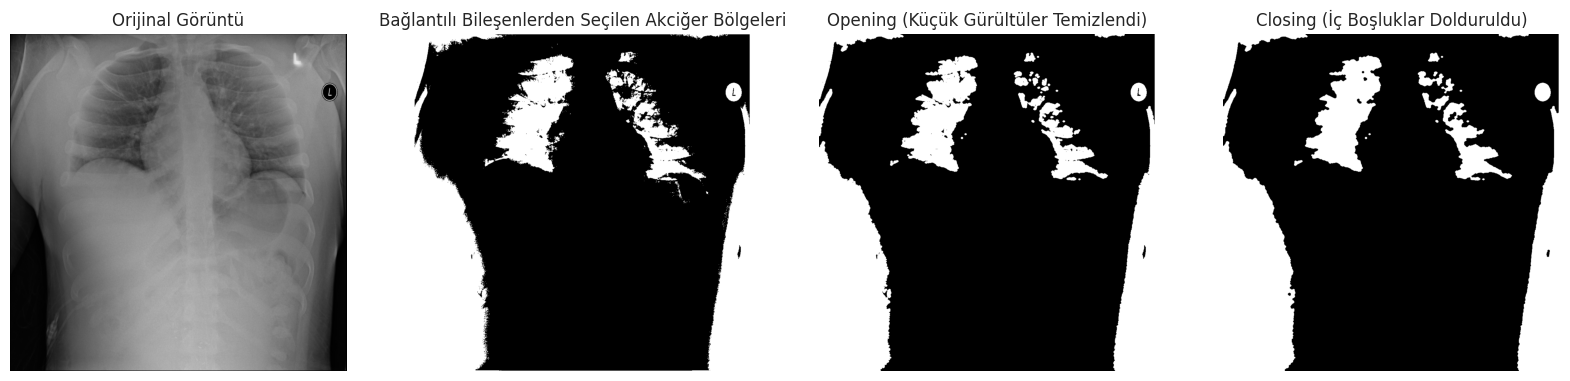

In [33]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, measure
from skimage.color import rgb2gray
from skimage.filters import threshold_otsu

def process_lung_regions(image_path):

    img = io.imread(image_path)
    if len(img.shape) == 3:
        img = rgb2gray(img)

    # Otsu thresholding uygulaması
    otsu_thresh = threshold_otsu(img)
    binary = (img > otsu_thresh).astype(np.uint8)

    # Bağlantılı bileşenleri bulalım
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(binary, connectivity=8)

    # Alanlara göre büyükten küçüğe sıralayalım
    sorted_indices = np.argsort(-stats[:, cv2.CC_STAT_AREA])

    # En büyük iki bölgeyi seçlim
    lung_candidates = sorted_indices[1:3]

    lung_regions = []

    for idx in lung_candidates:
        centroid_x, centroid_y = centroids[idx]
        img_width = img.shape[1]

        # Akciğerler göğüs kafesinin ortasında bulunmalı
        if 0.3 * img_width < centroid_x < 0.7 * img_width:
            lung_regions.append(idx)

    # Eğer iki bölge bulunamazsa, üçüncü en büyük bölgeyi de deniyoruz
    if len(lung_regions) < 2 and len(sorted_indices) > 3:
        third_candidate = sorted_indices[3]
        centroid_x, centroid_y = centroids[third_candidate]
        if 0.3 * img_width < centroid_x < 0.7 * img_width:
            lung_regions.append(third_candidate)

    # Eğer hala yeterli bölge yoksa, en büyük iki bölgeyi zorla seçtiriyoruz
    if len(lung_regions) < 2:
        lung_regions = sorted_indices[1:3]

    # Seçilen bölgelerin maskesini oluşturuyoruz
    lung_mask = np.isin(labels, lung_regions).astype(np.uint8)

    # MORFOLOJİK İŞLEMLER
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7, 7))  # Eliptik yapıtaşı seçtik

    lung_mask_opened = cv2.morphologyEx(lung_mask, cv2.MORPH_OPEN, kernel)   # Küçük gürültüleri temizledik
    lung_mask_closed = cv2.morphologyEx(lung_mask_opened, cv2.MORPH_CLOSE, kernel)  # İç boşlukları kapattk

    # Görselleştirmesi
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    axes[0].imshow(img, cmap="gray")
    axes[0].set_title("Orijinal Görüntü")
    axes[0].axis("off")

    axes[1].imshow(lung_mask, cmap="gray")
    axes[1].set_title("Bağlantılı Bileşenlerden Seçilen Akciğer Bölgeleri")
    axes[1].axis("off")

    axes[2].imshow(lung_mask_opened, cmap="gray")
    axes[2].set_title("Opening (Küçük Gürültüler Temizlendi)")
    axes[2].axis("off")

    axes[3].imshow(lung_mask_closed, cmap="gray")
    axes[3].set_title("Closing (İç Boşluklar Dolduruldu)")
    axes[3].axis("off")

    plt.show()

# Örnek görüntü seçip analizi yapalım
sample_image = "nih/images_small/" + train_df.sample(1)["Image"].values[0]
process_lung_regions(sample_image)


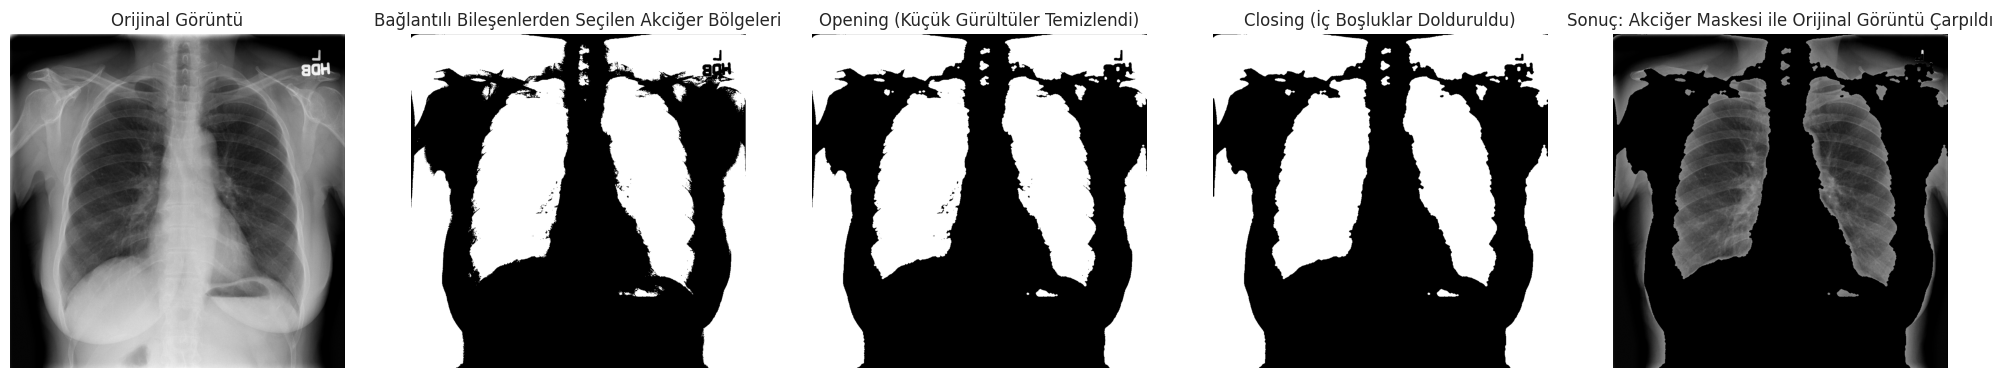

In [34]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, measure
from skimage.color import rgb2gray
from skimage.filters import threshold_otsu

def process_lung_regions(image_path):

    img = io.imread(image_path)
    if len(img.shape) == 3:
        img = rgb2gray(img)

    # Otsu thresholding uygulaması
    otsu_thresh = threshold_otsu(img)
    binary = (img > otsu_thresh).astype(np.uint8)

    # Bağlantılı bileşenleri buluyorum
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(binary, connectivity=8)

    # Alanlara göre büyükten küçüğe sıralayalım
    sorted_indices = np.argsort(-stats[:, cv2.CC_STAT_AREA])

    # En büyük iki bölgeyi seçleim
    lung_candidates = sorted_indices[1:3]

    lung_regions = []

    for idx in lung_candidates:
        centroid_x, centroid_y = centroids[idx]
        img_width = img.shape[1]

        # Akciğerler göğüs kafesinin ortasında bulunmalı
        if 0.3 * img_width < centroid_x < 0.7 * img_width:
            lung_regions.append(idx)

    # Eğer iki bölge bulunamazsa, üçüncü en büyük bölgeyi de deneyelim
    if len(lung_regions) < 2 and len(sorted_indices) > 3:
        third_candidate = sorted_indices[3]
        centroid_x, centroid_y = centroids[third_candidate]
        if 0.3 * img_width < centroid_x < 0.7 * img_width:
            lung_regions.append(third_candidate)

    # Eğer hala yeterli bölge yoksa, en büyük iki bölgeyi zorla seçtiriyoruz
    if len(lung_regions) < 2:
        lung_regions = sorted_indices[1:3]

    # Seçilen bölgelerin maskesini oluşturuyoruz
    lung_mask = np.isin(labels, lung_regions).astype(np.uint8)

    # MORFOLOJİK İŞLEMLER
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7, 7))  # Eliptik yapıtaşı seçtik
    lung_mask_opened = cv2.morphologyEx(lung_mask, cv2.MORPH_OPEN, kernel)   # Gürültü temizliği
    lung_mask_closed = cv2.morphologyEx(lung_mask_opened, cv2.MORPH_CLOSE, kernel)  # Boşlukları kapatma

    # Nihai Maske ile Orijinal Görüntüyü Çarpalım
    segmented_lungs = img * lung_mask_closed  # Maske ile orijinal görüntüyü çarpıyoruz

    # Görselleştirmesi
    fig, axes = plt.subplots(1, 5, figsize=(25, 5))
    axes[0].imshow(img, cmap="gray")
    axes[0].set_title("Orijinal Görüntü")
    axes[0].axis("off")

    axes[1].imshow(lung_mask, cmap="gray")
    axes[1].set_title("Bağlantılı Bileşenlerden Seçilen Akciğer Bölgeleri")
    axes[1].axis("off")

    axes[2].imshow(lung_mask_opened, cmap="gray")
    axes[2].set_title("Opening (Küçük Gürültüler Temizlendi)")
    axes[2].axis("off")

    axes[3].imshow(lung_mask_closed, cmap="gray")
    axes[3].set_title("Closing (İç Boşluklar Dolduruldu)")
    axes[3].axis("off")

    axes[4].imshow(segmented_lungs, cmap="gray")
    axes[4].set_title("Sonuç: Akciğer Maskesi ile Orijinal Görüntü Çarpıldı")
    axes[4].axis("off")

    plt.show()

# Örnek görüntü seçip analizi yapalım
sample_image = "nih/images_small/" + train_df.sample(1)["Image"].values[0]
process_lung_regions(sample_image)


1. Orijinal görüntü
2. Bağlantılı bileşenlerden seçilen akciğer maskesi
3. Opening (Küçük parçalar temizlendi)
4. Closing (İç boşluklar dolduruldu)
* Sonuç: Akciğer maskesi ile filtrelenmiş görüntü

* Elde edilen maske sayesinde akciğer bölgeleri net bir şekilde ortaya çıktı.
* Bağlantılı bileşen analizi, morfolojik işlemler ve maske çarpma işlemi başarılı şekilde uygulandı.
- Son aşamada, sadece akciğer bölgelerini içeren temiz bir görüntü elde edildi.